In [38]:
import datashader as ds
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datashader import transfer_functions as tf

from functools import partial
from datashader.utils import export_image

## Sobre o jogo
League of Legends é um jogo de estratégia em que duas equipes de cinco, entre mais de 140, poderosos Campeões se enfrentam para destruir a base uma da outra. O mapa é dividido em três rotas, chamadas de rota superior, rota do meio e rota inferior, além da selva, que é o espaço que compreende o intervalo entre as rotas. O Nexus é o grande objetivo do jogo. Ele fica localizado ao centro da base inimiga, dentro do mapa, e precisa ser destruído para que você alcance a vitória. Porém, a tarefa não é fácil, já que ele é protegido pelo caminho por torres, tropas e campeões do time adversário. Além disso, o Nexus tem uma vida longa e nem sempre será fácil destroçá-lo. Manter o controle das tropas nas rotas é fundamental, pois sem elas, não é possível derrubar uma torre, além de serem a principal fonte de obtenção de ouro na partida.

## Insights
Para o conjunto de dados obtido, o objetivo é a obtenção da resposta para algumas questões iniciais, tais como:
- Quais os campeões mais selecionados no último ano (2018) em ligas profissionais e porquê;
- Quais os locais do mapa com maior quantidade de abates baseado no tempo de jogo e porquê?

## Limpeza de dados
Para atingir tais objetivos, serão utilizados os dados referentes à partidas de ligas profissionais, nos anos de 2015 até 2018, disponíveis no Kaggle [aqui](https://www.kaggle.com/chuckephron/leagueoflegends). Para obter os dados referentes à seleção de campeões, será utilizado o dataset `LeagueofLegends.csv`.

In [6]:
cols = ['Year', 'redTopChamp', 'redJungleChamp', 'redMiddleChamp', 'redADCChamp', 'redSupportChamp',
       'blueTopChamp', 'blueJungleChamp', 'blueMiddleChamp', 'blueADCChamp', 'blueSupportChamp']

picks = pd.read_csv('datasets/LeagueofLegends.csv')
picks.head()

,League,Year,Season,Type,blueTeamTag,bResult,rResult,redTeamTag,gamelength,golddiff,...,redMiddleChamp,goldredMiddle,redADC,redADCChamp,goldredADC,redSupport,redSupportChamp,goldredSupport,redBans,Address
0,NALCS,2015,Spring,Season,TSM,1,0,C9,40,"[0, 0, -14, -65, -268, -431, -488, -789, -494,...",...,Fizz,"[475, 475, 552, 842, 1178, 1378, 1635, 1949, 2...",Sneaky,Sivir,"[475, 475, 532, 762, 1097, 1469, 1726, 2112, 2...",LemonNation,Thresh,"[515, 515, 577, 722, 911, 1042, 1194, 1370, 14...","['Tristana', 'Leblanc', 'Nidalee']",http://matchhistory.na.leagueoflegends.com/en/...
1,NALCS,2015,Spring,Season,CST,0,1,DIG,38,"[0, 0, -26, -18, 147, 237, -152, 18, 88, -242,...",...,Azir,"[475, 475, 552, 786, 1097, 1389, 1660, 1955, 2...",CoreJJ,Corki,"[475, 475, 532, 868, 1220, 1445, 1732, 1979, 2...",KiWiKiD,Annie,"[515, 515, 583, 752, 900, 1066, 1236, 1417, 15...","['RekSai', 'Janna', 'Leblanc']",http://matchhistory.na.leagueoflegends.com/en/...
2,NALCS,2015,Spring,Season,WFX,1,0,GV,40,"[0, 0, 10, -60, 34, 37, 589, 1064, 1258, 913, ...",...,Azir,"[475, 475, 533, 801, 1006, 1233, 1385, 1720, 1...",Cop,Corki,"[475, 475, 533, 781, 1085, 1398, 1782, 1957, 2...",BunnyFuFuu,Janna,"[515, 515, 584, 721, 858, 1002, 1168, 1303, 14...","['Leblanc', 'Zed', 'RekSai']",http://matchhistory.na.leagueoflegends.com/en/...
3,NALCS,2015,Spring,Season,TIP,0,1,TL,41,"[0, 0, -15, 25, 228, -6, -243, 175, -346, 16, ...",...,Lulu,"[475, 475, 532, 771, 1046, 1288, 1534, 1776, 2...",KEITH,KogMaw,"[475, 475, 532, 766, 1161, 1438, 1776, 1936, 2...",Xpecial,Janna,"[515, 515, 583, 721, 870, 1059, 1205, 1342, 15...","['RekSai', 'Rumble', 'LeeSin']",http://matchhistory.na.leagueoflegends.com/en/...
4,NALCS,2015,Spring,Season,CLG,1,0,T8,35,"[40, 40, 44, -36, 113, 158, -121, -191, 23, 20...",...,Lulu,"[475, 475, 532, 807, 1042, 1338, 1646, 1951, 2...",Maplestreet8,Corki,"[475, 475, 532, 792, 1187, 1488, 1832, 2136, 2...",Dodo8,Annie,"[475, 475, 538, 671, 817, 948, 1104, 1240, 136...","['Rumble', 'Sivir', 'Rengar']",http://matchhistory.na.leagueoflegends.com/en/...


Este é o formato dos nossos dados. Como queremos trabalhar apenas com os campeões selecionados e o ano sendo 2018, iremos filtrar as colunas indesejadas.

In [7]:
cols = ['Year', 'redTopChamp', 'redJungleChamp', 'redMiddleChamp', 'redADCChamp', 'redSupportChamp',
       'blueTopChamp', 'blueJungleChamp', 'blueMiddleChamp', 'blueADCChamp', 'blueSupportChamp']
picks = pd.read_csv('datasets/LeagueofLegends.csv', usecols=cols, index_col=0)
picks.head()

,blueTopChamp,blueJungleChamp,blueMiddleChamp,blueADCChamp,blueSupportChamp,redTopChamp,redJungleChamp,redMiddleChamp,redADCChamp,redSupportChamp
Year,,,,,,,,,,
2015,Irelia,RekSai,Ahri,Jinx,Janna,Gnar,Elise,Fizz,Sivir,Thresh
2015,Gnar,Rengar,Ahri,Caitlyn,Leona,Irelia,JarvanIV,Azir,Corki,Annie
2015,Renekton,Rengar,Fizz,Sivir,Annie,Sion,LeeSin,Azir,Corki,Janna
2015,Irelia,JarvanIV,Leblanc,Sivir,Thresh,Gnar,Nunu,Lulu,KogMaw,Janna
2015,Gnar,JarvanIV,Lissandra,Tristana,Janna,Sion,RekSai,Lulu,Corki,Annie


Nosso conjunto de dados referentes à seleção de campeões está configurado. Agora, é necessário obter os dados referentes à abates em locais específicos do mapa. O dataset `kills.csv` armazena essa informação, portanto, precisamos importá-lo.

In [14]:
kills = pd.read_csv('datasets/kills.csv')
kills.head()

,Address,Team,Time,Victim,Killer,Assist_1,Assist_2,Assist_3,Assist_4,x_pos,y_pos
0,http://matchhistory.na.leagueoflegends.com/en/...,bKills,10.820,C9 Hai,TSM Bjergsen,NaN,NaN,NaN,NaN,9229,8469
1,http://matchhistory.na.leagueoflegends.com/en/...,bKills,16.286,C9 LemonNation,TSM WildTurtle,TSM Santorin,TSM Bjergsen,TSM Lustboy,NaN,13908,5960
2,http://matchhistory.na.leagueoflegends.com/en/...,bKills,18.733,C9 Hai,TSM Bjergsen,TSM Santorin,TSM WildTurtle,TSM Lustboy,NaN,8281,7889
3,http://matchhistory.na.leagueoflegends.com/en/...,bKills,18.880,C9 Meteos,TSM Dyrus,TSM Santorin,TSM Bjergsen,TSM WildTurtle,TSM Lustboy,8522,8895
4,http://matchhistory.na.leagueoflegends.com/en/...,bKills,27.005,C9 Balls,TSM Bjergsen,TSM Dyrus,TSM Santorin,TSM WildTurtle,TSM Lustboy,8902,7643


Diferentemente do conjunto de dados anterior, precisamos efetuar algumas alterações nos dados. A primeira logo mais evidente é o tipo de dado nas colunas "x_pos" e "y_pos", que estão em formato de string. Para nossos objetivos, devemos convertê-las em float. Além disso, existem registros com o valor "TooEarly" em todos os campos, o que não será utilizado e pode ser descartado. A coluna Time será renomeada para "time", buscando uma padronização. 

Como também utilizaremos apenas os campos "x_pos", "y_pos" e "time", podemos filtrar o resto.

In [58]:
kills = pd.read_csv('datasets/kills.csv', usecols=['Time', 'x_pos', 'y_pos'])
kills.drop(kills[kills['x_pos'] == 'TooEarly'].index, inplace=True)
kills.dropna()
kills.rename(columns={'Time': 'time'}, inplace=True)

for col in kills.columns:
    kills[col] = kills[col].apply(lambda x: float(x))

Esta é a aparência do nosso DataFrame.

In [59]:
kills.head()

,time,x_pos,y_pos
0,10.820,9229.0,8469.0
1,16.286,13908.0,5960.0
2,18.733,8281.0,7889.0
3,18.880,8522.0,8895.0
4,27.005,8902.0,7643.0


Uma última alteração é necessária. Para podermos plotar o mapa de abates, é interessante classificar o tempo que ocorreram, ao invés de minutos, em fase do jogo. Uma partida de League of Legends é dividida em três fases: early game (início da partida), mid game (meio da partida) e late game (final da partida). Porém, as partidas nem sempre são iguais, então o que define essas etapas? Para responder a isso, podemos utilizar a função `describe()` do DataFrame.

In [60]:
kills['time'].describe()

count    190823.000000
mean         24.545016
std          11.152311
min           0.845000
25%          16.018500
50%          24.637000
75%          32.174500
max          94.536000
Name: time, dtype: float64

De acordo com o resultado, o tempo de jogo é dividido da seguinte forma:
- early game: 0min ~> 16min
- mid game: 16min ~> 24min
- late game: 24min ~> final do jogo

Com essa informação, podemos classificar os dados de time em uma nova coluna, denominada game_phase, que irá informar em qual etapa do jogo ocorreu o abate.

In [61]:
bins = [0, 16, 24, 32]
names = ['early_game', 'mid_game', 'late_game']
kills['game_phase'] = pd.cut(kills['time'], bins, labels=names)
kills.drop(columns=['time'], inplace=True)
kills.head()

,x_pos,y_pos,game_phase
0,9229.0,8469.0,early_game
1,13908.0,5960.0,mid_game
2,8281.0,7889.0,mid_game
3,8522.0,8895.0,mid_game
4,8902.0,7643.0,late_game


O campo "time" não é mais necessário, portanto, podemos eliminá-lo do DataFrame. Com isso, temos tudo que é necessário para a etapa de visualização.

## Visualização de Dados

O draft é uma das principais condições de vitória de um time. Além das características como força em cada momento de jogo, em partidas competitivas existe um outro atributo chamado de meta, ou seja, itens, armas, personagens, cartas, estratégias, técnicas e abordagens que estão mais dominantes ou populares no LoL. Muitas vezes, determinado campeão recebe melhorias, chamado de buff, o que pode o tornar desproporcionalmente forte em relação a outros, o que o torna prioridade no draft. Podemos analisar os campeões mais selecionados em cada rota para determinar o meta daquele ano.

In [62]:
blueTop2018 = picks.loc[2018, 'blueTopChamp'].value_counts()[:10]
redTop2018 = picks.loc[2018, 'redTopChamp'].value_counts()[:10]

blueJungle2018 = picks.loc[2018, 'blueJungleChamp'].value_counts()[:10]
redJungle2018 = picks.loc[2018, 'redJungleChamp'].value_counts()[:10]

blueMid2018 = picks.loc[2018, 'blueMiddleChamp'].value_counts()[:10]
redMid2018 = picks.loc[2018, 'redMiddleChamp'].value_counts()[:10]

blueAdc2018 = picks.loc[2018, 'blueADCChamp'].value_counts()[:10]
redAdc2018 = picks.loc[2018, 'redADCChamp'].value_counts()[:10]

blueSupport2018 = picks.loc[2018, 'blueSupportChamp'].value_counts()[:10]
redSupport2018 = picks.loc[2018, 'redSupportChamp'].value_counts()[:10]

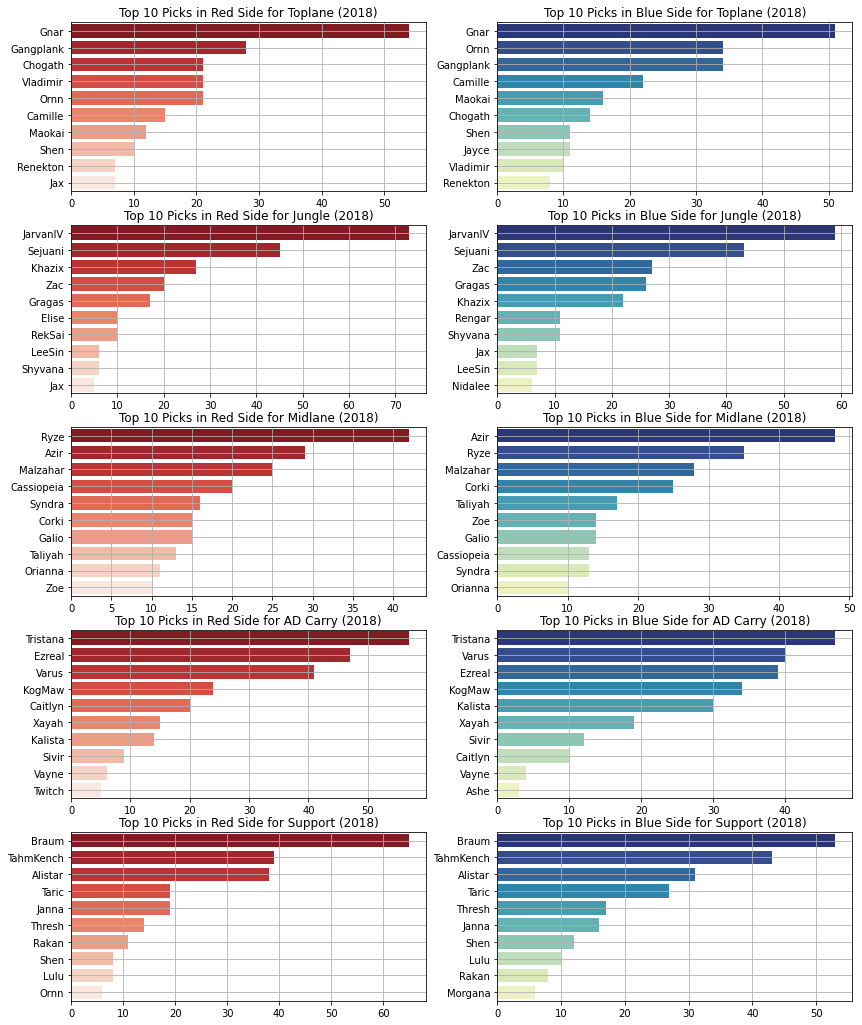

In [63]:
fig, ax = plt.subplots(figsize=(14, 18), ncols=2, nrows=5)

sns.barplot(y=redTop2018.index, x=redTop2018.values,label="Red Side", palette="Reds_r", ax=ax[0][0])
sns.barplot(y=blueTop2018.index, x=blueTop2018.values,label="Blue Side", palette='YlGnBu_r', ax=ax[0][1])

sns.barplot(y=redJungle2018.index, x=redJungle2018.values,label="Red Side", palette="Reds_r", ax=ax[1][0])
sns.barplot(y=blueJungle2018.index, x=blueJungle2018.values,label="Blue Side", palette='YlGnBu_r', ax=ax[1][1])

sns.barplot(y=redMid2018.index, x=redMid2018.values,label="Red Side", palette="Reds_r", ax=ax[2][0])
sns.barplot(y=blueMid2018.index, x=blueMid2018.values,label="Blue Side", palette='YlGnBu_r', ax=ax[2][1])

sns.barplot(y=redAdc2018.index, x=redAdc2018.values,label="Red Side", palette="Reds_r", ax=ax[3][0])
sns.barplot(y=blueAdc2018.index, x=blueAdc2018.values,label="Blue Side", palette='YlGnBu_r', ax=ax[3][1])

sns.barplot(y=redSupport2018.index, x=redSupport2018.values,label="Red Side", palette="Reds_r", ax=ax[4][0])
sns.barplot(y=blueSupport2018.index, x=blueSupport2018.values,label="Blue Side", palette='YlGnBu_r', ax=ax[4][1])

ax[0][0].set_title('Top 10 Picks in Red Side for Toplane (2018)')
ax[0][0].grid(True)
ax[0][1].set_title('Top 10 Picks in Blue Side for Toplane (2018)')
ax[0][1].grid(True)

ax[1][0].set_title('Top 10 Picks in Red Side for Jungle (2018)')
ax[1][0].grid(True)
ax[1][1].set_title('Top 10 Picks in Blue Side for Jungle (2018)')
ax[1][1].grid(True)

ax[2][0].set_title('Top 10 Picks in Red Side for Midlane (2018)')
ax[2][0].grid(True)
ax[2][1].set_title('Top 10 Picks in Blue Side for Midlane (2018)')
ax[2][1].grid(True)

ax[3][0].set_title('Top 10 Picks in Red Side for AD Carry (2018)')
ax[3][0].grid(True)
ax[3][1].set_title('Top 10 Picks in Blue Side for AD Carry (2018)')
ax[3][1].grid(True)

ax[4][0].set_title('Top 10 Picks in Red Side for Support (2018)')
ax[4][0].grid(True)
ax[4][1].set_title('Top 10 Picks in Blue Side for Support (2018)')
ax[4][1].grid(True)

Na época, campeões que buildavam com itens de tanque se beneficiavam muito de seus atributos, ou seja, constituiam uma linha de frente que resistia duante muito tempo na linha de frente. Podemos observar os 4 campeões mais selecionados na role de suporte / selva como sendo tanks. Porém, o ápice do poder dos tanks se encontrava no mid game. Qual a solução que os times encontraram para contornar isso? Utilizar campeões de scaling na sua composição: Vladimir, Gangplank, Jax (na top lane), Ryze, Azir, Cassiopeia, Corki (na mid lane), Tristana, Varus, Ezreal, Kog'Maw (na bot lane). É interessante de destacar que o meta de tank era forte pois os itens para campeões tank eram mais baratos em comparação a outros itens de alto dano, ou seja, roles que absorviam pouco recurso, como é o caso dos caçadores e suportes, se beneficiavam muito mais de tais itens.

Respondendo a segunda questão levantada, quais são os lugares do mapa onde ocorrem mais abates, baseados no tempo de jogo? Nosso dataframe de abates nos fornece três informações: tempo de jogo onde aconteceu um abate e suas coordenadas (x,y) no mapa. Com isso, podemos construir um gráfico juntando todas essas informações.

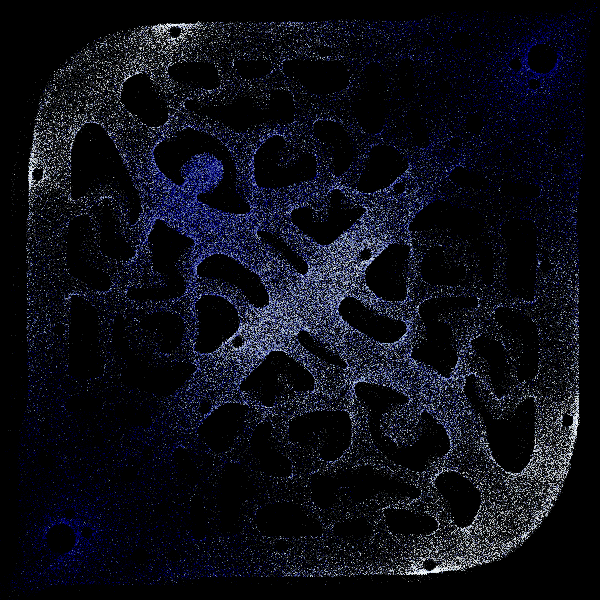

In [65]:
canvas = ds.Canvas()
agg = canvas.points(kills, 'x_pos', 'y_pos', ds.count_cat('game_phase'))
color_key = {'early_game': 'white', 'mid_game': 'lightblue', 'late_game': 'navy'}

export = partial(export_image, background="black", export_path="images")

tf.set_background(tf.shade(agg, color_key=color_key), 'black')

Algumas conclusões possíveis ao observar o gráfico: 
- Os abates no early game concentram-se ao redor das torres tier 1;
- Os abates no mid game concentram-se no rio, próximos ao pit do Dragão e do Arauto / Barão. Neste período, ocorrem as primeiras lutas em equipe, ou seja, os times deixam suas rotas para contestar algum objetivo neutro do mapa.
- Os abates no late game concentram-se na base de algum dos times. O jogo está próximo do fim!